### 04 - HEAT WAVES IDENTIFICATION

#### 04.1 - Libraries import

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import dask as ds
from datetime import datetime

#### 04.2 - Temporal patterns analysis
##### Here we start analyzing the datasets containing the temperatures, spanning across all years months days available from 11 am to 5 pm

In [4]:
# Open the file NetCDF

dataset_t1 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\2m_air_temp\air_temperature_era5-downscaled-over-italy_hourly_81_00.nc")
dataset_t2 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\2m_air_temp\air_temperature_era5-downscaled-over-italy_hourly_01_23.nc")
dataset_tmax1 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-downscaled-over-italy_hourly_81_00.nc")
dataset_tmax2 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-downscaled-over-italy_hourly_01_23.nc")

#### 04.3 - Unione dei datasets

In [11]:
# Specifica la cartella di output e il nome del file unito
output_folder = (r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp")
output_file = "max_temperature_era5-81_23.nc"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Apri i dataset
ds1 = dataset_tmax1
ds2 = dataset_tmax2

# Unisci i dataset
merged_ds = xr.concat([ds1, ds2], dim="time")

# Salva il dataset unito in un nuovo file NetCDF
output_path = os.path.join(output_folder, output_file)
merged_ds.to_netcdf(output_path)

print(f'Dataset unito salvato in: {output_path}')

Dataset unito salvato in: C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc


In [5]:
dataset_tmax = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
dataset_t = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\2m_air_temp\air_temperature_era5-81_23.nc")

In [48]:
dataset_tmax

<xarray.Dataset>
Dimensions:                         (time: 109935, rlat: 103, rlon: 114)
Coordinates:
    lon                             (rlat, rlon) float32 ...
    height_2m                       float32 ...
  * rlon                            (rlon) float64 -2.553 -2.533 ... -0.2932
  * rlat                            (rlat) float64 1.652 1.672 ... 3.672 3.692
    lat                             (rlat, rlon) float32 ...
  * time                            (time) datetime64[ns] 1981-01-01T11:00:00...
Data variables:
    TMAX_2M                         (time, rlat, rlon) float32 ...
    crs_rotated_latitude_longitude  (time) int64 ...
Attributes: (12/14)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    history:         Generated by CMCC DDS version 0.9.0 2025-03-26 09:15:33....
    source:          COSMO
    institution:     CMCC (Euro-Mediterranean Center on Climate Change), REMH...
    title:           cclm-sp_2.4_terra_urb_2.3.1 simulation (0.02 Deg) forced...
    ...              ...
    conventionsURL:  http://www.cfconventions.org/
    contact:         Mario Raffa (mario.raffa@cmcc.it)- Marianna Adinolfi (ma...
    references:      http//www.clm-community.eu, http://www.cmcc.it
    creation_date:   2022-10-22 00:28:52
    grid_mapping:    rotated_pole
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

#### 04.4 - Analisi media annua e mensile su tutto il dataset

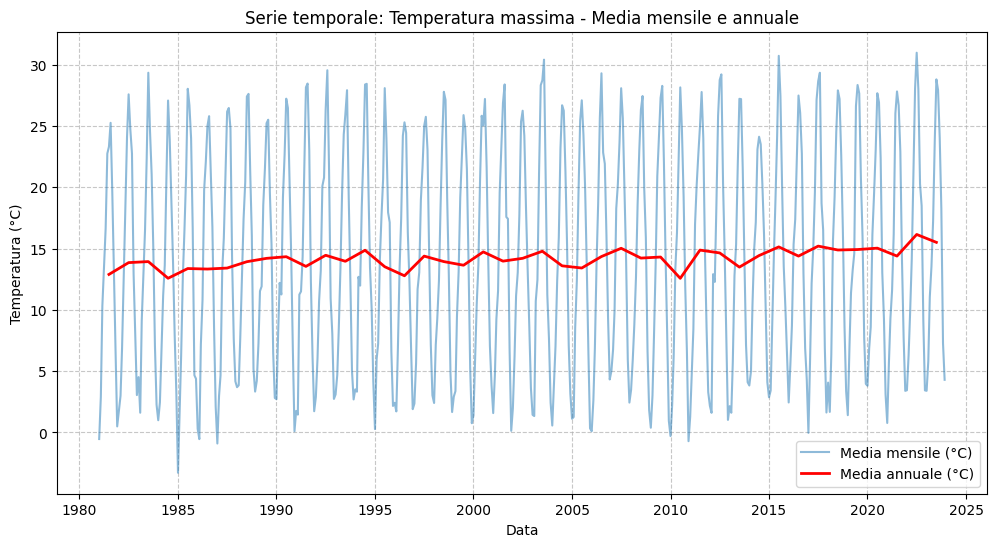

In [5]:
# Applica il chunking al dataset già caricato per lavorare con Dask
ds = dataset_tmax.chunk({"time": 365, "rlat": 50, "rlon": 50})

# Seleziona la variabile di interesse (assicurati che il nome sia corretto, qui "TMAX_2M")
temp_var = ds["TMAX_2M"]

# 1) Calcolo della media spaziale giornaliera (riducendo rlat, rlon)
temp_mean = temp_var.mean(dim=["rlat", "rlon"]) - 273.15  # da K a °C
temp_mean_computed = temp_mean.compute()

# 2) Conversione in DataFrame e creazione di colonne 'year' e 'month'
df_mean = temp_mean_computed.to_dataframe().reset_index()  # 'time' diventa colonna
df_mean['year'] = df_mean['time'].dt.year
df_mean['month'] = df_mean['time'].dt.month

# 3) Raggruppo per (year, month) per ottenere la media mensile
monthly_mean = df_mean.groupby(['year', 'month'])['TMAX_2M'].mean().reset_index()

# 4) Raggruppo per year per ottenere la media annuale
annual_mean = df_mean.groupby('year')['TMAX_2M'].mean().reset_index()

# 5) Creazione di una colonna 'date' fittizia per plottare la serie mensile
#    (usiamo il 1° giorno di ogni mese)
monthly_mean['date'] = pd.to_datetime(dict(
    year=monthly_mean['year'],
    month=monthly_mean['month'],
    day=1
))
monthly_mean.sort_values('date', inplace=True)

#    Per l'annuale, creiamo una data fittizia (es. 1° luglio) per ogni anno
annual_mean['date'] = pd.to_datetime(dict(
    year=annual_mean['year'],
    month=7,   # mese "centrale" dell'anno
    day=1
))
annual_mean.sort_values('date', inplace=True)

# 6) Plot delle due serie (mensile e annuale) in un unico grafico
plt.figure(figsize=(12, 6))

# Media mensile
plt.plot(
    monthly_mean['date'],
    monthly_mean['TMAX_2M'],
    label="Media mensile (°C)",
    alpha=0.5
)

# Media annuale
plt.plot(
    annual_mean['date'],
    annual_mean['TMAX_2M'],
    label="Media annuale (°C)",
    color="red",
    linewidth=2
)

plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.title("Serie temporale: Temperatura massima - Media mensile e annuale")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

#### 04.5 - Definizione delle soglie per ciascun giorno con finestra a 15 e a 31 giorni
Attenzione a runnare il codice ci impiega un paio d'ore

In [7]:
start = datetime.now()

def compute_dayofyear_thresholds(
    ds, 
    var_name, 
    percentile, 
    window_1, 
    window_2
):
    """
    Calcola per ciascun day_of_year due soglie:
      - threshold_15: basata su una finestra centrata di 15 giorni
      - threshold_31: basata su una finestra centrata di 31 giorni
    
    Restituisce un DataFrame con:
      day_of_year, threshold_15, threshold_31
    """
    # Aggiunge una coordinata "dayofyear"
    ds = ds.assign_coords(dayofyear=ds.time.dt.dayofyear)

    half_1 = window_1 // 2
    half_2 = window_2 // 2

    results = []

    for d in range(1, 366):
        # Finestra 15 giorni (±7)
        day_min_1 = d - half_1
        day_max_1 = d + half_1
        ds_w1 = ds.where(
            (ds.dayofyear >= day_min_1) & (ds.dayofyear <= day_max_1),
            drop=True
        ).chunk({"time": -1, "rlat": -1, "rlon": -1})  # Rechunk per avere chunk unici
        
        if ds_w1[var_name].size > 0:
            threshold_15 = ds_w1[var_name].quantile(
                percentile, dim=["time", "rlat", "rlon"]
            ).compute()
            threshold_15_val = float(threshold_15.values)
        else:
            threshold_15_val = np.nan

        # Finestra 31 giorni (±15)
        day_min_2 = d - half_2
        day_max_2 = d + half_2
        ds_w2 = ds.where(
            (ds.dayofyear >= day_min_2) & (ds.dayofyear <= day_max_2),
            drop=True
        ).chunk({"time": -1, "rlat": -1, "rlon": -1})
        
        if ds_w2[var_name].size > 0:
            threshold_31 = ds_w2[var_name].quantile(
                percentile, dim=["time", "rlat", "rlon"]
            ).compute()
            threshold_31_val = float(threshold_31.values)
        else:
            threshold_31_val = np.nan

        results.append({
            "day_of_year": d,
            "threshold_15": threshold_15_val,
            "threshold_31": threshold_31_val
        })

    df_thresholds = pd.DataFrame(results)
    return df_thresholds


# CALCOLIAMO ADESSO LE SOGLIE PER CIASCUN GIORNO DEL DATASET
# Applica il chunking al dataset già caricato per lavorare con Dask
dataset_tmax = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
ds = dataset_tmax.chunk({"time": 365, "rlat": 50, "rlon": 50})

# Seleziona la variabile di interesse (assicurati che il nome sia corretto, qui "TMAX_2M")
temp_var = ds["TMAX_2M"]

df_thresholds = compute_dayofyear_thresholds(
    ds,
    var_name="TMAX_2M",  # Adatta al tuo dataset
    percentile=0.90,
    window_1=15,
    window_2=31
    )

end = datetime.now()
elapsed = end - start
print(f"Elapsed Time using datetime: {elapsed}")

Elapsed Time using datetime: 1:46:52.794235


In [35]:
df_thresholds

,day_of_year,date,month_number,day_num,month_name,year
0,1,2023-01-01,1,1,January,2023
1,2,2023-01-02,1,2,January,2023
2,3,2023-01-03,1,3,January,2023
3,4,2023-01-04,1,4,January,2023
4,5,2023-01-05,1,5,January,2023
...,...,...,...,...,...,...
360,361,2023-12-27,12,27,December,2023
361,362,2023-12-28,12,28,December,2023
362,363,2023-12-29,12,29,December,2023
363,364,2023-12-30,12,30,December,2023


In [53]:
# 1. Leggi il file CSV in un DataFrame
df = pd.read_csv("thresholds_15_31.csv")

In [54]:
df

,day_of_year,threshold_15,threshold_31
0,1,280.962952,281.123260
1,2,280.984589,281.133026
2,3,281.036987,281.138977
3,4,281.060120,281.130646
4,5,281.088165,281.127319
...,...,...,...
360,361,281.481201,281.564972
361,362,281.472137,281.546600
362,363,281.489685,281.539429
363,364,281.376343,281.560638


In [55]:
# Assumiamo come anno di riferimento il 2023
# Creiamo una colonna 'date' a partire da '2023-01-01' sommando i giorni (day_of_year - 1)
df['date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(df['day_of_year'] - 1, unit='D')

# Aggiungiamo una colonna per il numero del mese
df['month_num'] = df['date'].dt.month

# Aggiungiamo una colonna per il numero del mese
df['day_num'] = df['date'].dt.day

# Aggiungiamo una colonna per il nome del mese
df['month_name'] = df['date'].dt.month_name()

df.drop(columns=["date"], inplace=True)

# Visualizza le prime righe del DataFrame
print(df.head(60))

    day_of_year  threshold_15  threshold_31  month_num  day_num month_name
0             1    280.962952    281.123260          1        1    January
1             2    280.984589    281.133026          1        2    January
2             3    281.036987    281.138977          1        3    January
3             4    281.060120    281.130646          1        4    January
4             5    281.088165    281.127319          1        5    January
5             6    281.115509    281.137177          1        6    January
6             7    281.135782    281.142517          1        7    January
7             8    281.124084    281.149841          1        8    January
8             9    281.136383    281.152130          1        9    January
9            10    281.166779    281.153534          1       10    January
10           11    281.182739    281.170593          1       11    January
11           12    281.185150    281.189667          1       12    January
12           13    281.20

In [56]:
# Salva in CSV
df.to_csv("thresholds_15_31.csv", index=False)
print("CSV salvato con le soglie per ciascun day_of_year.")

CSV salvato con le soglie per ciascun day_of_year.


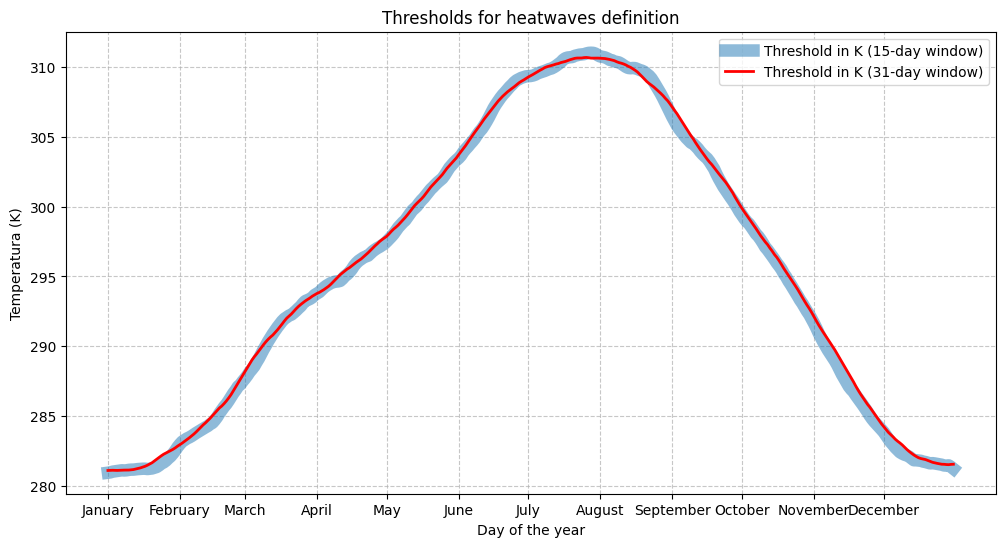

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Traccia le serie
plt.plot(
    df['day_of_year'],
    df['threshold_15'],
    label="Threshold in K (15-day window)",
    alpha=0.5,
    linewidth=9.0
)
plt.plot(
    df['day_of_year'],
    df['threshold_31'],
    label="Threshold in K (31-day window)",
    color="red",
    linewidth=2
)

plt.xlabel("Day of the year")
plt.ylabel("Temperatura (K)")
plt.title("Thresholds for heatwaves definition")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Estrai, per ogni mese, il primo giorno (o un giorno rappresentativo) e il nome del mese
# In questo esempio, usiamo drop_duplicates sul numero del mese per ottenere una riga per ciascun mese
unique_months = df.drop_duplicates(subset="month_num")

# Imposta i tick dell'asse x: posizione = day_of_year, etichetta = month_name
plt.xticks(unique_months["day_of_year"], unique_months["month_name"])

plt.show()

## Estrazione dataset di heatwaves su un anno specifico

#### 04.6 - Identificazione delle heat waves per un anno specifico

In [35]:
import xarray as xr
import pandas as pd
import numpy as np

# Parametri modificabili
TARGET_YEAR = 2010          # Anno da analizzare
THRESHOLD_CHOICE = "31"     # Scegli "15" o "31" a seconda della finestra che vuoi utilizzare (la finestra che fa riferimento a quella che abbiamo usato per calcolare la soglia con il 90°percentile

# 1) Carica il dataset NetCDF e applica chunking
ds = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
ds = ds.chunk({"time": 365, "rlat": 50, "rlon": 50})

# Filtra per l'anno TARGET_YEAR
start_date = f"{TARGET_YEAR}-01-01"
end_date   = f"{TARGET_YEAR}-12-31"
ds_year = ds.sel(time=slice(start_date, end_date))
ds_year = ds_year.chunk({"time": -1})  # Forza la dimensione "time" in un unico chunk

# 2) Aggiungi la coordinata "time_floor" arrotondata al giorno
ds_year = ds_year.assign_coords(time_floor=ds_year.time.dt.floor("D"))

# 3) Rechunk rlat/rlon in un unico chunk per i calcoli dei quantili
var_single = ds_year["TMAX_2M"].chunk({"rlat": -1, "rlon": -1})

# 4) Calcola le statistiche giornaliere usando groupby su "time_floor"
ds_daily_mean   = var_single.groupby("time_floor").mean(dim=["rlat", "rlon"]).compute()
ds_daily_median = var_single.groupby("time_floor").quantile(0.5,  dim=["rlat", "rlon"]).compute()
ds_daily_p90    = var_single.groupby("time_floor").quantile(0.90, dim=["rlat", "rlon"]).compute()
ds_daily_p95    = var_single.groupby("time_floor").quantile(0.95, dim=["rlat", "rlon"]).compute()
ds_daily_max    = var_single.groupby("time_floor").max(dim=["rlat", "rlon"]).compute()

# 5) Converte ogni DataArray in DataFrame e rinomina "time_floor" in "Date"
df_mean   = ds_daily_mean.to_dataframe(name="Mean").reset_index()[["time_floor", "Mean"]].rename(columns={"time_floor": "Date"})
df_median = ds_daily_median.to_dataframe(name="Median").reset_index()[["time_floor", "Median"]].rename(columns={"time_floor": "Date"})
df_p90    = ds_daily_p90.to_dataframe(name="P90").reset_index()[["time_floor", "P90"]].rename(columns={"time_floor": "Date"})
df_p95    = ds_daily_p95.to_dataframe(name="P95").reset_index()[["time_floor", "P95"]].rename(columns={"time_floor": "Date"})
df_max    = ds_daily_max.to_dataframe(name="Max").reset_index()[["time_floor", "Max"]].rename(columns={"time_floor": "Date"})

# 6) Unisci le statistiche in un unico DataFrame
df_stats = (
    df_mean
    .merge(df_median, on="Date", how="left")
    .merge(df_p90,    on="Date", how="left")
    .merge(df_p95,    on="Date", how="left")
    .merge(df_max,    on="Date", how="left")
)
df_stats.drop_duplicates(subset=["Date"], inplace=True)

# 7) Aggiungi la colonna day_of_year e gestisci gli anni bisestili
df_stats["day_of_year"] = pd.to_datetime(df_stats["Date"]).dt.dayofyear
df_stats["day_of_year_noleap"] = df_stats["day_of_year"]
leap_mask = pd.to_datetime(df_stats["Date"]).dt.is_leap_year & (df_stats["day_of_year"] > 60)
df_stats.loc[leap_mask, "day_of_year_noleap"] = df_stats.loc[leap_mask, "day_of_year"] - 1

# 8) Carica il CSV delle soglie
df_threshold = pd.read_csv("thresholds_15_31.csv")

# 9) Merge delle statistiche con il CSV delle soglie
df_merged = pd.merge(
    df_stats,
    df_threshold,
    left_on="day_of_year_noleap",
    right_on="day_of_year",
    how="left"
)

# 10) Converti le statistiche in Celsius
stat_cols = ["Mean", "Median", "P90", "P95", "Max"]
for col in stat_cols:
    df_merged[col] = df_merged[col] - 273.15

# Converti anche le soglie (se presenti)
if "threshold_15" in df_merged.columns:
    df_merged["threshold_15"] = df_merged["threshold_15"] - 273.15
if "threshold_31" in df_merged.columns:
    df_merged["threshold_31"] = df_merged["threshold_31"] - 273.15

# 11) Confronta le statistiche con la soglia scelta
chosen_threshold_col = f"threshold_{THRESHOLD_CHOICE}"
col_mean   = f"Mean>{chosen_threshold_col}"
col_median = f"Median>{chosen_threshold_col}"
col_p90    = f"P90>{chosen_threshold_col}"
col_p95    = f"P95>{chosen_threshold_col}"
col_max    = f"Max>{chosen_threshold_col}"

df_merged[col_mean]   = np.where(df_merged["Mean"]   > df_merged[chosen_threshold_col], "Yes", "No")
df_merged[col_median] = np.where(df_merged["Median"] > df_merged[chosen_threshold_col], "Yes", "No")
df_merged[col_p90]    = np.where(df_merged["P90"]    > df_merged[chosen_threshold_col], "Yes", "No")
df_merged[col_p95]    = np.where(df_merged["P95"]    > df_merged[chosen_threshold_col], "Yes", "No")
df_merged[col_max]    = np.where(df_merged["Max"]    > df_merged[chosen_threshold_col], "Yes", "No")

# 12) Calcola la colonna "heat_wave" con blocchi consecutivi
# Se in un giorno almeno uno dei confronti (Mean, Median, P90, P95, Max) è "Yes", quel giorno è "heatwave".
# Tutti i giorni consecutivi in un blocco di heat wave verranno etichettati con la lunghezza TOTALE del blocco.

# Definisci le colonne di confronto
cols_to_check = [col_mean, col_median, col_p90, col_p95, col_max]

# Ordina il DataFrame per Data e reindicizza
df_merged.sort_values("Date", inplace=True)
df_merged.reset_index(drop=True, inplace=True)

# Array booleana: True se giorno di heat wave, False se "nella norma"
is_hw = df_merged.apply(lambda row: any(row[c] == "Yes" for c in cols_to_check), axis=1)

heat_wave_result = [None]*len(df_merged)

i = 0
n = len(df_merged)
while i < n:
    if is_hw[i]:
        # inizia un blocco di heat wave
        start = i
        while i < n and is_hw[i]:
            i += 1
        # adesso i è l'indice del primo giorno fuori dal blocco o fine array
        run_length = i - start  # lunghezza del blocco consecutivo
        # Assegna a tutti i giorni del blocco la stringa con la lunghezza
        label = f"{run_length} giorno"
        for j in range(start, i):
            heat_wave_result[j] = label
    else:
        # giorno nella norma
        heat_wave_result[i] = "nella norma"
        i += 1

df_merged["heat_wave"] = heat_wave_result

# 13) Droppa eventuali colonne inutili
cols_to_drop = ["day_of_year_x", "day_of_year_noleap"]
df_merged.drop(columns=cols_to_drop, errors="ignore", inplace=True)

# 14) Salva il risultato
output_filename = f"heatwave_events_window{THRESHOLD_CHOICE}_{TARGET_YEAR}.csv"
df_merged.to_csv(output_filename, index=False)
print(f"File '{output_filename}' creato con successo!")

File 'heatwave_events_window31_2010.csv' creato con successo!


In [33]:
df_merged

,Date,Mean,Median,P90,P95,Max,day_of_year_y,threshold_15,threshold_31,month_num,day_num,month_name,Mean>threshold_31,Median>threshold_31,P90>threshold_31,P95>threshold_31,Max>threshold_31,heat_wave
0,2010-01-01,2.796448,4.905618,6.592480,7.062370,9.061829,1,7.812952,7.973260,1,1,January,No,No,No,No,Yes,1 giorno
1,2010-01-02,-0.957520,2.351785,6.108896,6.663474,7.955475,2,7.834589,7.983026,1,2,January,No,No,No,No,No,nella norma
2,2010-01-03,-3.969391,-0.762350,0.619650,0.927878,4.029083,3,7.886987,7.988977,1,3,January,No,No,No,No,No,nella norma
3,2010-01-04,-4.488464,-2.224478,-0.225711,0.137560,2.008514,4,7.910120,7.980646,1,4,January,No,No,No,No,No,nella norma
4,2010-01-05,-2.545197,-0.741431,0.587814,1.121042,4.259094,5,7.938165,7.977319,1,5,January,No,No,No,No,No,nella norma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2010-12-27,-3.788422,-0.933340,1.072278,1.224347,3.719452,361,8.331201,8.414972,12,27,December,No,No,No,No,No,nella norma
361,2010-12-28,-2.136993,-0.581015,0.361377,0.553397,3.953003,362,8.322137,8.396600,12,28,December,No,No,No,No,No,nella norma
362,2010-12-29,-0.711578,0.126672,1.128284,1.492146,4.953644,363,8.339685,8.389429,12,29,December,No,No,No,No,No,nella norma
363,2010-12-30,0.219757,0.893335,2.336346,2.756546,5.427063,364,8.226343,8.410638,12,30,December,No,No,No,No,No,nella norma


#### 04.7 - Calcolo della heatwave cumulative intensity a partire dal dataframe generato nel blocco sovrastante per un anno specifico

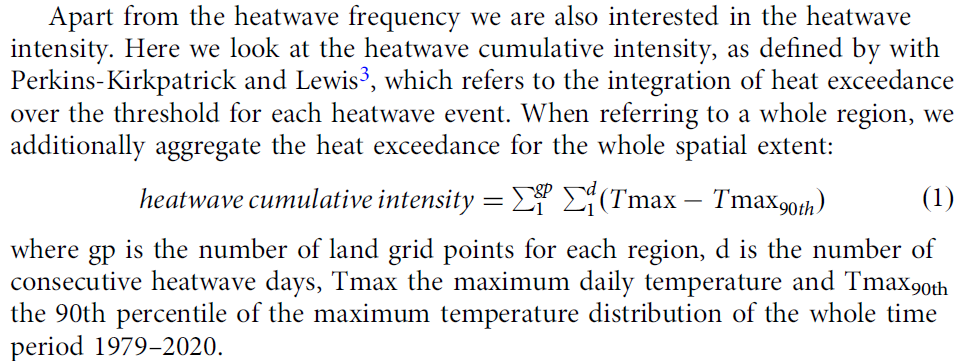

In [53]:
import xarray as xr
import pandas as pd
import numpy as np

# ===============================
# PARAMETRI E FUNZIONI UTILI
# ===============================
TARGET_YEAR = 2010           # Anno da analizzare
THRESHOLD_CHOICE = "31"      # "15" o "31" per la soglia universale da usare
CSV_SOGGETTO = "thresholds_15_31.csv"  # CSV con day_of_year, threshold_15, threshold_31 (in Kelvin)

def is_leap_year(year: int) -> bool:
    """Ritorna True se l'anno è bisestile, False altrimenti."""
    return (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0))

def day_of_year_noleap(date: pd.Timestamp) -> int:
    """
    Restituisce il day_of_year 'noleap' per la data passata.
    Se l'anno è bisestile e day_of_year > 60, sottrae 1.
    """
    doy = date.day_of_year
    if is_leap_year(date.year) and doy > 60:
        return doy - 1
    else:
        return doy

def get_heatwave_events(df_merged: pd.DataFrame) -> list:
    """
    Dato df_merged con colonne 'Date' (datetime) e 'heat_wave' (diverso da "nella norma"),
    restituisce una lista di eventi, ognuno è una lista di date consecutive (almeno 3 giorni).
    """
    hw_days = df_merged.loc[df_merged["heat_wave"] != "nella norma"].copy()
    hw_days.sort_values("Date", inplace=True)
    hw_days.reset_index(drop=True, inplace=True)
    
    events = []
    current_block = []
    prev_date = None
    for _, row in hw_days.iterrows():
        this_date = pd.to_datetime(row["Date"])
        if not current_block:
            current_block = [this_date]
            prev_date = this_date
        else:
            if (this_date - prev_date).days == 1:
                current_block.append(this_date)
                prev_date = this_date
            else:
                if len(current_block) >= 3:
                    events.append(current_block)
                current_block = [this_date]
                prev_date = this_date
    if current_block and len(current_block) >= 3:
        events.append(current_block)
    return events

def load_threshold_map(csv_file: str, threshold_choice: str) -> dict:
    """
    Carica il CSV delle soglie e restituisce un dizionario {day_of_year_noleap: soglia_in_Celsius}.
    Il CSV è in Kelvin e viene convertito in Celsius.
    """
    df_thr = pd.read_csv(csv_file)
    df_thr.set_index("day_of_year", inplace=True)
    chosen_col = f"threshold_{threshold_choice}"
    # Converti da Kelvin a Celsius
    df_thr[chosen_col] = df_thr[chosen_col] - 273.15
    return df_thr[chosen_col].to_dict()

def daily_max_for_date(date: pd.Timestamp, ds_subdaily: xr.Dataset) -> xr.DataArray:
    """
    Dato un dataset sub-daily (ds_subdaily) con dimensione 'time', 
    seleziona i record corrispondenti al giorno 'date' (usando dt.floor("D"))
    e calcola la Tmax pixel-based.
    Ritorna un DataArray con dimensioni (rlat, rlon).
    """
    day_sel = ds_subdaily.where(ds_subdaily.time.dt.floor("D") == date, drop=True)
    if day_sel.time.size == 0:
        return xr.DataArray(np.nan, dims=())
    tmax_day = day_sel["TMAX_2M"].max(dim="time")
    return tmax_day

# ===============================
# CODICE PRINCIPALE
# ===============================

# 1) Carica df_merged (si assume esista già in memoria; altrimenti, caricalo da CSV)
# Ad esempio:
# df_merged = pd.read_csv("df_merged.csv", parse_dates=["Date"])

# 2) Estrai gli eventi di heat wave (blocchi consecutivi di almeno 3 giorni)
events = get_heatwave_events(df_merged)

# 3) Carica il dataset originale sub-daily e filtra per TARGET_YEAR
ds_original = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
ds_original = ds_original.sel(time=slice(f"{TARGET_YEAR}-01-01", f"{TARGET_YEAR}-12-31"))
# Converti TMAX_2M da Kelvin a Celsius
ds_original["TMAX_2M"] = ds_original["TMAX_2M"] - 273.15

# 4) Carica la mappa delle soglie (in Celsius) dal CSV
thr_map = load_threshold_map(CSV_SOGGETTO, THRESHOLD_CHOICE)

# 5) Calcola l'intensità cumulativa per ciascun evento
result_list = []
for block in events:
    start_day = block[0]
    end_day = block[-1]
    duration_days = (end_day - start_day).days + 1
    
    total_intensity = 0.0
    # Per ogni giorno dell'evento:
    for day in block:
        # Calcola day_of_year_noleap per il giorno
        doy_noleap = day_of_year_noleap(day)
        # Ottieni la soglia universale (in Celsius) per quel giorno
        thr_val = thr_map.get(doy_noleap, np.nan)
        if np.isnan(thr_val):
            continue
        # Calcola Tmax pixel-based per quel giorno (in Celsius)
        tmax_pix = daily_max_for_date(day, ds_original)  # DataArray (rlat, rlon)
        if tmax_pix.size == 1 and np.isnan(tmax_pix.item()):
            continue
        # Calcola la differenza (eccedenza): (Tmax - soglia), clip a 0
        diff = xr.where((tmax_pix - thr_val) > 0, tmax_pix - thr_val, 0.0)
        # Somma la differenza su tutte le dimensioni spaziali (ad es. "rlat" e "rlon")
        dims_to_sum = list(diff.dims)
        daily_intensity = diff.sum(dim=dims_to_sum).item()
        total_intensity += daily_intensity
    
    result_list.append({
        "start_date": start_day,
        "end_date": end_day,
        "duration": duration_days,
        "heatwave_cumulative_intensity": total_intensity
    })

df_events = pd.DataFrame(result_list)
print(df_events)

  start_date   end_date  duration  heatwave_cumulative_intensity
0 2010-04-19 2010-04-21         3                   11481.724854
1 2010-04-28 2010-05-01         4                   25075.270752
2 2010-06-10 2010-06-13         4                   13146.480591
3 2010-07-02 2010-07-04         3                   19886.037109
4 2010-07-10 2010-07-17         8                  122314.917969
5 2010-11-14 2010-11-17         4                    4444.892853
6 2010-12-07 2010-12-09         3                    2742.485453
7 2010-12-22 2010-12-25         4                    5329.140968


## Estrazione dataset di heatwaves sull'intero intervallo temporale 1981-2023

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import time

# ===============================
# PARAMETRI
# ===============================
START_YEAR = 1981
END_YEAR   = 2023 
THRESHOLD_CHOICE = "31"  # "15" o "31"
CSV_THRESHOLDS = "thresholds_15_31.csv"  # CSV con day_of_year, threshold_15, threshold_31 in Kelvin

# ===============================
# FUNZIONI DI SUPPORTO
# ===============================
def is_leap_year(year: int) -> bool:
    return (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0))

def get_heatwave_blocks(is_hw_bool: pd.Series) -> list:
    """
    Dato un array booleano is_hw_bool (True = giorno di heat wave, False = nella norma),
    restituisce la colonna "heat_wave" con la lunghezza TOTALE del blocco consecutivo.
    Ritorna una lista di stringhe (es. "3 giorno", "nella norma").
    """
    n = len(is_hw_bool)
    heat_wave_result = [None]*n
    i = 0
    while i < n:
        if is_hw_bool.iloc[i]:
            start = i
            while i < n and is_hw_bool.iloc[i]:
                i += 1
            run_length = i - start
            label = f"{run_length} giorno"
            for j in range(start, i):
                heat_wave_result[j] = label
        else:
            heat_wave_result[i] = "nella norma"
            i += 1
    return heat_wave_result

# ===============================
# CARICAMENTO UNA TANTUM
# ===============================
# Carica il dataset NetCDF (in Kelvin) una volta sola
ds_all = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\Enlarged_datasets\max_air_temp\max_temperature_era5-81_23.nc")
ds_all = ds_all.chunk({"time": 365, "rlat": 50, "rlon": 50})

# Carica il CSV delle soglie (in Kelvin)
df_thresholds = pd.read_csv(CSV_THRESHOLDS)
df_thresholds.set_index("day_of_year", inplace=True)

# Creiamo un elenco per accumulare i DataFrame annuali
df_list_all_years = []

for year in range(START_YEAR, END_YEAR + 1):
    t0 = time.time()
    year_str = str(year)
    
    # ---------------------------
    # 1) Filtra il dataset per l'anno
    # ---------------------------
    ds_year = ds_all.sel(time=slice(f"{year_str}-01-01", f"{year_str}-12-31"))
    ds_year = ds_year.chunk({"time": -1})  # Minimizza i chunk su "time"
    
    # ---------------------------
    # 2) Assegna la coordinata "time_floor" arrotondata al giorno
    # ---------------------------
    ds_year = ds_year.assign_coords(time_floor=ds_year.time.dt.floor("D"))
    
    # ---------------------------
    # 3) Calcola le statistiche giornaliere (Mean, Median, P90, P95, Max) usando groupby su "time_floor"
    #    e converti in DataFrame
    # ---------------------------
    var_single = ds_year["TMAX_2M"].chunk({"rlat": -1, "rlon": -1})
    
    ds_daily_mean   = var_single.groupby("time_floor").mean(dim=["rlat", "rlon"]).compute()
    ds_daily_median = var_single.groupby("time_floor").quantile(0.5,  dim=["rlat", "rlon"]).compute()
    ds_daily_p90    = var_single.groupby("time_floor").quantile(0.90, dim=["rlat", "rlon"]).compute()
    ds_daily_p95    = var_single.groupby("time_floor").quantile(0.95, dim=["rlat", "rlon"]).compute()
    ds_daily_max    = var_single.groupby("time_floor").max(dim=["rlat", "rlon"]).compute()
    
    df_mean   = ds_daily_mean.to_dataframe(name="Mean").reset_index()[["time_floor", "Mean"]].rename(columns={"time_floor": "Date"})
    df_median = ds_daily_median.to_dataframe(name="Median").reset_index()[["time_floor", "Median"]].rename(columns={"time_floor": "Date"})
    df_p90    = ds_daily_p90.to_dataframe(name="P90").reset_index()[["time_floor", "P90"]].rename(columns={"time_floor": "Date"})
    df_p95    = ds_daily_p95.to_dataframe(name="P95").reset_index()[["time_floor", "P95"]].rename(columns={"time_floor": "Date"})
    df_max    = ds_daily_max.to_dataframe(name="Max").reset_index()[["time_floor", "Max"]].rename(columns={"time_floor": "Date"})
    
    # Unisci le statistiche
    df_stats = (
        df_mean
        .merge(df_median, on="Date", how="left")
        .merge(df_p90,    on="Date", how="left")
        .merge(df_p95,    on="Date", how="left")
        .merge(df_max,    on="Date", how="left")
    )
    df_stats.drop_duplicates(subset=["Date"], inplace=True)
    
    # ---------------------------
    # 4) day_of_year e day_of_year_noleap + Merge con CSV soglie
    # ---------------------------
    df_stats["Date"] = pd.to_datetime(df_stats["Date"])
    df_stats["day_of_year"] = df_stats["Date"].dt.dayofyear
    df_stats["day_of_year_noleap"] = df_stats["day_of_year"]
    # Gestisci anni bisestili
    leap_mask = (df_stats["Date"].dt.is_leap_year) & (df_stats["day_of_year"] > 60)
    df_stats.loc[leap_mask, "day_of_year_noleap"] = df_stats.loc[leap_mask, "day_of_year"] - 1
    
    # Merge con df_thresholds
    df_stats_merged = pd.merge(
        df_stats,
        df_thresholds.reset_index(),  # "day_of_year" come colonna
        left_on="day_of_year_noleap",
        right_on="day_of_year",
        how="left"
    )
    
    # ---------------------------
    # 5) Converti in Celsius
    # ---------------------------
    stat_cols = ["Mean", "Median", "P90", "P95", "Max"]
    for col in stat_cols:
        df_stats_merged[col] = df_stats_merged[col] - 273.15  # dataset originale in Kelvin
    
    # Converti la soglia selezionata
    thr_col = f"threshold_{THRESHOLD_CHOICE}"
    if thr_col in df_stats_merged.columns:
        df_stats_merged[thr_col] = df_stats_merged[thr_col] - 273.15
    
    # ---------------------------
    # 6) Confronto e definizione colonna "heat_wave"
    # ---------------------------
    # Creiamo i confronti "Mean>threshold_xxx", etc.
    col_mean   = f"Mean>{thr_col}"
    col_median = f"Median>{thr_col}"
    col_p90    = f"P90>{thr_col}"
    col_p95    = f"P95>{thr_col}"
    col_max    = f"Max>{thr_col}"
    
    df_stats_merged[col_mean]   = np.where(df_stats_merged["Mean"]   > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_median] = np.where(df_stats_merged["Median"] > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_p90]    = np.where(df_stats_merged["P90"]    > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_p95]    = np.where(df_stats_merged["P95"]    > df_stats_merged[thr_col], "Yes", "No")
    df_stats_merged[col_max]    = np.where(df_stats_merged["Max"]    > df_stats_merged[thr_col], "Yes", "No")
    
    # Ordina per Date
    df_stats_merged.sort_values("Date", inplace=True)
    df_stats_merged.reset_index(drop=True, inplace=True)
    
    # Creiamo un array booleano: True se almeno una colonna di confronto è "Yes"
    comp_cols = [col_mean, col_median, col_p90, col_p95, col_max]
    is_hw_bool = df_stats_merged.apply(lambda row: any(row[c] == "Yes" for c in comp_cols), axis=1)
    
    # Costruiamo la colonna "heat_wave" come blocchi consecutivi
    heat_wave_result = []
    i_idx = 0
    n_idx = len(df_stats_merged)
    while i_idx < n_idx:
        if is_hw_bool.iloc[i_idx]:
            start_i = i_idx
            while i_idx < n_idx and is_hw_bool.iloc[i_idx]:
                i_idx += 1
            run_len = i_idx - start_i
            label = f"{run_len} giorno"
            for j in range(start_i, i_idx):
                heat_wave_result.append(label)
        else:
            heat_wave_result.append("nella norma")
            i_idx += 1
    
    # Se la lunghezza non corrisponde, potremmo aver generato mismatch. 
    # Invece, costruiamo la lista via indexing:
    heat_wave_result_list = [None]*n_idx
    i_idx = 0
    while i_idx < n_idx:
        if is_hw_bool.iloc[i_idx]:
            start_i = i_idx
            while i_idx < n_idx and is_hw_bool.iloc[i_idx]:
                i_idx += 1
            run_len = i_idx - start_i
            label = f"{run_len} giorno"
            for j in range(start_i, i_idx):
                heat_wave_result_list[j] = label
        else:
            heat_wave_result_list[i_idx] = "nella norma"
            i_idx += 1
    
    df_stats_merged["heat_wave"] = heat_wave_result_list
    
    # Aggiungi una colonna "year"
    df_stats_merged["year"] = year
    
    # Salva in una lista
    df_list_all_years.append(df_stats_merged)
    
    # Tempo di esecuzione
    print(f"Anno {year} completato. Righe finali: {len(df_stats_merged)}")

# Concatenazione di tutti gli anni
df_final = pd.concat(df_list_all_years, ignore_index=True)
df_final.to_csv(f"heatwave_events_{START_YEAR}_{END_YEAR}_window{THRESHOLD_CHOICE}.csv", index=False)
print("Elaborazione completata, file CSV creato con successo!")


Anno 1981 completato. Righe finali: 365


#### 04.7 - Plot di max temperatures of a give year vs thresholds

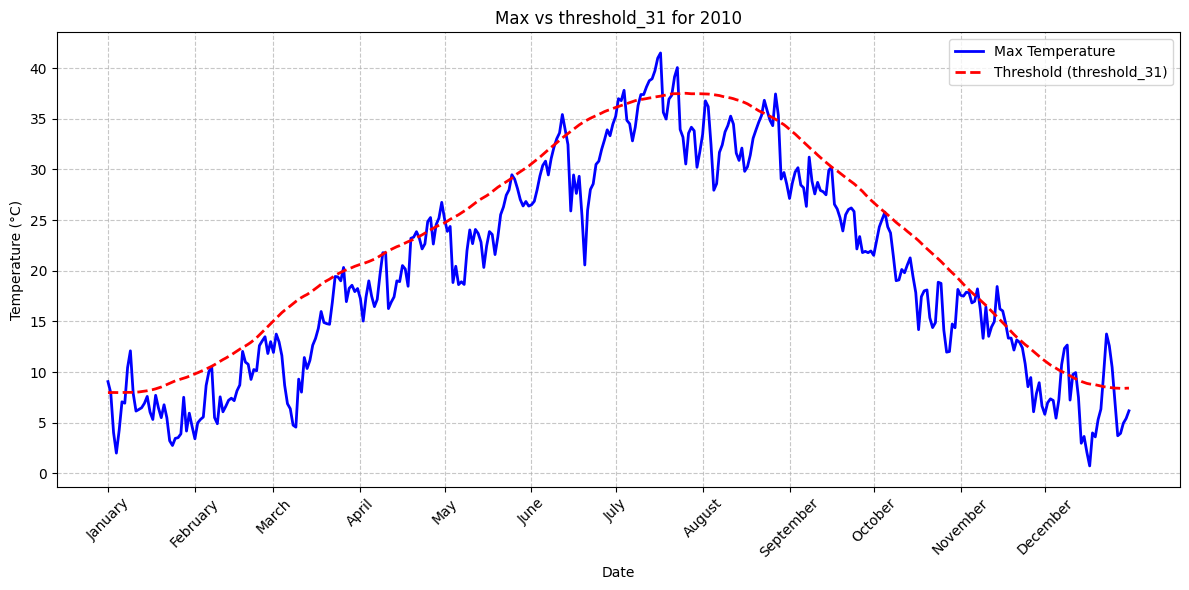

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Parametri di plotting
TARGET_YEAR = 2010            # Anno da plottare (lo stesso usato nella creazione di df_merged)
THRESHOLD_CHOICE = "31"       # Scegli "15" per usare la soglia a 15 giorni o "31" per quella a 31 giorni
STATISTIC_CHOICE = "Max"     # Scegli la statistica da plottare: "Mean", "Median", "P90", "P95" o "Max"

# Carica il DataFrame generato precedentemente con tutti i valori
df = df_merged
df["Date"] = pd.to_datetime(df["Date"])  # Assicura che la colonna Date sia datetime

# Definisci il nome della colonna della soglia in base a THRESHOLD_CHOICE
threshold_col = f"threshold_{THRESHOLD_CHOICE}"

# Crea il plot
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df[STATISTIC_CHOICE], label=f"{STATISTIC_CHOICE} Temperature", color="blue", linewidth=2)
plt.plot(df["Date"], df[threshold_col], label=f"Threshold ({threshold_col})", color="red", linestyle="--", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title(f"{STATISTIC_CHOICE} vs {threshold_col} for {TARGET_YEAR}")

# Imposta i tick dell'asse x con i nomi dei mesi
tick_dates = pd.date_range(start=f"{TARGET_YEAR}-01-01", end=f"{TARGET_YEAR}-12-31", freq="MS")
tick_labels = [d.strftime("%B") for d in tick_dates]
plt.xticks(tick_dates, tick_labels, rotation=45)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()